<a href="https://colab.research.google.com/github/brinda0301/Final-/blob/main/OSR_MEDAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing all the necessary libraries

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, Subset, ConcatDataset,random_split
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import label_binarize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [85]:
# Data augmentation and normalization transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset for training and validation
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Load CIFAR-100 dataset for testing as the unknown class
test_dataset_cifar100 = CIFAR100(root='./data', train=False, download=True, transform=transform_test)
# Remap all CIFAR-100 labels to '10' for the unknown class
for idx in range(len(test_dataset_cifar100.targets)):
    test_dataset_cifar100.targets[idx] = 10  # Set all CIFAR-100 as unknown class '10'

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# Test loader for open set recognition combines CIFAR-10 validation and CIFAR-100 test data
open_set_test_dataset = ConcatDataset([val_dataset, test_dataset_cifar100])
test_loader = DataLoader(open_set_test_dataset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


**MODEL ARCHITECTURE**

In [87]:
# Model Definition
class BasicBlock(nn.Module):
    expansion = 1# Expansion factor for the residual blocks

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # Residual function consists of two convolutional layers with batch normalization and ReLU activation
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * self.expansion)
        )
        # Shortcut connection to match dimensions if stride or channel dimensions change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        shortcut = self.shortcut(x)
        residual = self.residual_function(x)
        return F.relu(residual + shortcut, inplace=True)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=11):
        super(ResNet, self).__init__()
        self.in_channels = 64
         # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Layer blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Fully connected layer for classification
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
      # Forward pass through the layers
        out = F.relu(self.bn1(self.conv1(x)))
        f1 = self.layer1(out)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)
        f4 = self.layer4(f3)
        # Global average pooling
        gap = F.adaptive_avg_pool2d(f4, (1, 1))
        out = gap.view(gap.size(0), -1)
        # Fully connected layer for classification
        logits = self.linear(out)
        return logits, f4

# Attention Module
class AttentionModule(nn.Module):
    def __init__(self, num_features):
        super(AttentionModule, self).__init__()
        # This will create a weight for each feature map channel
        self.attention_weights = nn.Parameter(torch.randn(num_features))

    def forward(self, x):
        # Reshape attention weights to match the dimensions of the input feature maps
        attention_scores = F.softmax(self.attention_weights, dim=0).view(1, -1, 1, 1)
        # Element-wise multiplication with input feature maps
        return x * attention_scores

# Attention Diversity Loss
class AttentionDiversityLoss(nn.Module):
    def __init__(self):
        super(AttentionDiversityLoss, self).__init__()

    def forward(self, attentions):
        N = len(attentions)
        loss_d = 0.0
        # Compute diversity loss as the mean square of pairwise cosine similarities
        for i in range(N):
            for j in range(i + 1, N):
                loss_d += (1 - F.cosine_similarity(attentions[i], attentions[j], dim=1).mean())**2
        return loss_d / (N * (N - 1) / 2)

class AdvancedMultiBranchNet(nn.Module):
    def __init__(self, num_classes=11):
        super(AdvancedMultiBranchNet, self).__init__()
        # Experts (ResNet models)
        self.experts = nn.ModuleList([
            ResNet(BasicBlock, [2, 2, 2, 2], num_classes),
            ResNet(BasicBlock, [2, 2, 2, 2], num_classes),
            ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
        ])
        # Attention modules for each expert
        self.attentions = nn.ModuleList([AttentionModule(512) for _ in range(3)])
        # Gate network to combine expert predictions
        self.gate = nn.Sequential(
            nn.Linear(3 * 512, 3),
            nn.Softmax(dim=1)
        )
        # Diversity loss for attention modules
        self.diversity_loss = AttentionDiversityLoss()

    def forward(self, x):
        expert_outputs = []
        features = []
        attentions = []
        # Forward pass through each expert
        for idx, expert in enumerate(self.experts):
            logits, feature = expert(x)
            attended_feature = self.attentions[idx](feature)
            attentions.append(attended_feature)
            pooled_features = F.adaptive_avg_pool2d(attended_feature, (1, 1)).view(feature.size(0), -1)
            expert_outputs.append(logits)
            features.append(pooled_features)

        concatenated_features = torch.cat(features, dim=1)
        gate_weights = self.gate(concatenated_features)
        # Weighted combination of expert predictions
        final_output = torch.zeros_like(expert_outputs[0])
        for i, weight in enumerate(gate_weights.t()):
            final_output += weight.unsqueeze(-1) * expert_outputs[i]

        return final_output, expert_outputs, attentions

    def compute_loss(self, expert_logits, targets, attentions, beta1=0.1, beta2=0.1):
        if isinstance(expert_logits, list):
          # Combined cross-entropy loss from all experts
            L_ce_i = sum(F.cross_entropy(e_logits, targets) for e_logits in expert_logits)
        else:
            L_ce_i = F.cross_entropy(expert_logits, targets)
        L_d = self.diversity_loss(attentions)
        total_loss = L_ce_i + beta2 * L_d
        # Total loss combining cross-entropy and diversity loss
        return total_loss


def determine_optimal_threshold(val_loader, model, device, percentile=5):
    model.eval()
    softmax_scores = []
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            _, attentions = model(inputs)
            for attention_map in attentions:
                softmax_scores.extend(F.softmax(attention_map.flatten(), dim=0).cpu().numpy())
    return np.percentile(softmax_scores, percentile)

criterion = nn.CrossEntropyLoss()
model = AdvancedMultiBranchNet(num_classes=11).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


TRANING AND VALITAION LOOP

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/10] Training Loss: 6.3496
Train Metrics:
Expert 1 - Accuracy: 0.2518
Expert 2 - Accuracy: 0.2609
Expert 3 - Accuracy: 0.2569
Expert 1 - Auroc: 0.7360
Expert 2 - Auroc: 0.7378
Expert 3 - Auroc: 0.7332
Expert 1 - F1: 0.2122
Expert 2 - F1: 0.2194
Expert 3 - F1: 0.2203
Val Metrics:
Expert 1 - Accuracy: 0.3465
Expert 2 - Accuracy: 0.3690
Expert 3 - Accuracy: 0.3836
Expert 1 - Auroc: 0.8201
Expert 2 - Auroc: 0.8367
Expert 3 - Auroc: 0.8360
Expert 1 - F1: 0.3173
Expert 2 - F1: 0.3463
Expert 3 - F1: 0.3623


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [2/10] Training Loss: 4.8878
Train Metrics:
Expert 1 - Accuracy: 0.3752
Expert 2 - Accuracy: 0.4281
Expert 3 - Accuracy: 0.3948
Expert 1 - Auroc: 0.8285
Expert 2 - Auroc: 0.8596
Expert 3 - Auroc: 0.8412
Expert 1 - F1: 0.3576
Expert 2 - F1: 0.4128
Expert 3 - F1: 0.3803
Val Metrics:
Expert 1 - Accuracy: 0.4488
Expert 2 - Accuracy: 0.4578
Expert 3 - Accuracy: 0.4540
Expert 1 - Auroc: 0.8640
Expert 2 - Auroc: 0.8764
Expert 3 - Auroc: 0.8775
Expert 1 - F1: 0.4293
Expert 2 - F1: 0.4444
Expert 3 - F1: 0.4341


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [3/10] Training Loss: 4.2388
Train Metrics:
Expert 1 - Accuracy: 0.4529
Expert 2 - Accuracy: 0.5339
Expert 3 - Accuracy: 0.4703
Expert 1 - Auroc: 0.8694
Expert 2 - Auroc: 0.9022
Expert 3 - Auroc: 0.8790
Expert 1 - F1: 0.4438
Expert 2 - F1: 0.5265
Expert 3 - F1: 0.4610
Val Metrics:
Expert 1 - Accuracy: 0.5151
Expert 2 - Accuracy: 0.5919
Expert 3 - Accuracy: 0.5098
Expert 1 - Auroc: 0.8997
Expert 2 - Auroc: 0.9262
Expert 3 - Auroc: 0.9005
Expert 1 - F1: 0.5073
Expert 2 - F1: 0.5889
Expert 3 - F1: 0.4996


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [4/10] Training Loss: 3.6925
Train Metrics:
Expert 1 - Accuracy: 0.5205
Expert 2 - Accuracy: 0.6109
Expert 3 - Accuracy: 0.5462
Expert 1 - Auroc: 0.8990
Expert 2 - Auroc: 0.9289
Expert 3 - Auroc: 0.9073
Expert 1 - F1: 0.5154
Expert 2 - F1: 0.6085
Expert 3 - F1: 0.5423
Val Metrics:
Expert 1 - Accuracy: 0.5600
Expert 2 - Accuracy: 0.6493
Expert 3 - Accuracy: 0.5993
Expert 1 - Auroc: 0.9151
Expert 2 - Auroc: 0.9432
Expert 3 - Auroc: 0.9263
Expert 1 - F1: 0.5510
Expert 2 - F1: 0.6382
Expert 3 - F1: 0.5895


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [5/10] Training Loss: 3.2221
Train Metrics:
Expert 1 - Accuracy: 0.5887
Expert 2 - Accuracy: 0.6584
Expert 3 - Accuracy: 0.6131
Expert 1 - Auroc: 0.9220
Expert 2 - Auroc: 0.9443
Expert 3 - Auroc: 0.9299
Expert 1 - F1: 0.5859
Expert 2 - F1: 0.6572
Expert 3 - F1: 0.6107
Val Metrics:
Expert 1 - Accuracy: 0.6069
Expert 2 - Accuracy: 0.6470
Expert 3 - Accuracy: 0.6349
Expert 1 - Auroc: 0.9368
Expert 2 - Auroc: 0.9496
Expert 3 - Auroc: 0.9440
Expert 1 - F1: 0.6006
Expert 2 - F1: 0.6428
Expert 3 - F1: 0.6278


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [6/10] Training Loss: 2.8397
Train Metrics:
Expert 1 - Accuracy: 0.6364
Expert 2 - Accuracy: 0.6957
Expert 3 - Accuracy: 0.6663
Expert 1 - Auroc: 0.9389
Expert 2 - Auroc: 0.9549
Expert 3 - Auroc: 0.9472
Expert 1 - F1: 0.6346
Expert 2 - F1: 0.6955
Expert 3 - F1: 0.6650
Val Metrics:
Expert 1 - Accuracy: 0.6665
Expert 2 - Accuracy: 0.7034
Expert 3 - Accuracy: 0.7014
Expert 1 - Auroc: 0.9488
Expert 2 - Auroc: 0.9580
Expert 3 - Auroc: 0.9583
Expert 1 - F1: 0.6670
Expert 2 - F1: 0.7049
Expert 3 - F1: 0.7003


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [7/10] Training Loss: 2.5252
Train Metrics:
Expert 1 - Accuracy: 0.6746
Expert 2 - Accuracy: 0.7242
Expert 3 - Accuracy: 0.7119
Expert 1 - Auroc: 0.9499
Expert 2 - Auroc: 0.9631
Expert 3 - Auroc: 0.9598
Expert 1 - F1: 0.6737
Expert 2 - F1: 0.7240
Expert 3 - F1: 0.7115
Val Metrics:
Expert 1 - Accuracy: 0.7091
Expert 2 - Accuracy: 0.7591
Expert 3 - Accuracy: 0.7450
Expert 1 - Auroc: 0.9594
Expert 2 - Auroc: 0.9698
Expert 3 - Auroc: 0.9693
Expert 1 - F1: 0.7067
Expert 2 - F1: 0.7574
Expert 3 - F1: 0.7450


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [8/10] Training Loss: 2.2855
Train Metrics:
Expert 1 - Accuracy: 0.7018
Expert 2 - Accuracy: 0.7499
Expert 3 - Accuracy: 0.7442
Expert 1 - Auroc: 0.9574
Expert 2 - Auroc: 0.9696
Expert 3 - Auroc: 0.9678
Expert 1 - F1: 0.7015
Expert 2 - F1: 0.7498
Expert 3 - F1: 0.7444
Val Metrics:
Expert 1 - Accuracy: 0.7378
Expert 2 - Accuracy: 0.7864
Expert 3 - Accuracy: 0.7747
Expert 1 - Auroc: 0.9642
Expert 2 - Auroc: 0.9756
Expert 3 - Auroc: 0.9738
Expert 1 - F1: 0.7377
Expert 2 - F1: 0.7832
Expert 3 - F1: 0.7748


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [9/10] Training Loss: 2.0699
Train Metrics:
Expert 1 - Accuracy: 0.7309
Expert 2 - Accuracy: 0.7768
Expert 3 - Accuracy: 0.7719
Expert 1 - Auroc: 0.9643
Expert 2 - Auroc: 0.9750
Expert 3 - Auroc: 0.9735
Expert 1 - F1: 0.7309
Expert 2 - F1: 0.7772
Expert 3 - F1: 0.7722
Val Metrics:
Expert 1 - Accuracy: 0.7581
Expert 2 - Accuracy: 0.7995
Expert 3 - Accuracy: 0.8007
Expert 1 - Auroc: 0.9701
Expert 2 - Auroc: 0.9794
Expert 3 - Auroc: 0.9782
Expert 1 - F1: 0.7584
Expert 2 - F1: 0.7997
Expert 3 - F1: 0.7992


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [10/10] Training Loss: 1.9039
Train Metrics:
Expert 1 - Accuracy: 0.7536
Expert 2 - Accuracy: 0.7936
Expert 3 - Accuracy: 0.7878
Expert 1 - Auroc: 0.9702
Expert 2 - Auroc: 0.9782
Expert 3 - Auroc: 0.9773
Expert 1 - F1: 0.7541
Expert 2 - F1: 0.7940
Expert 3 - F1: 0.7881
Val Metrics:
Expert 1 - Accuracy: 0.7692
Expert 2 - Accuracy: 0.8028
Expert 3 - Accuracy: 0.7879
Expert 1 - Auroc: 0.9741
Expert 2 - Auroc: 0.9800
Expert 3 - Auroc: 0.9789
Expert 1 - F1: 0.7678
Expert 2 - F1: 0.8031
Expert 3 - F1: 0.7892


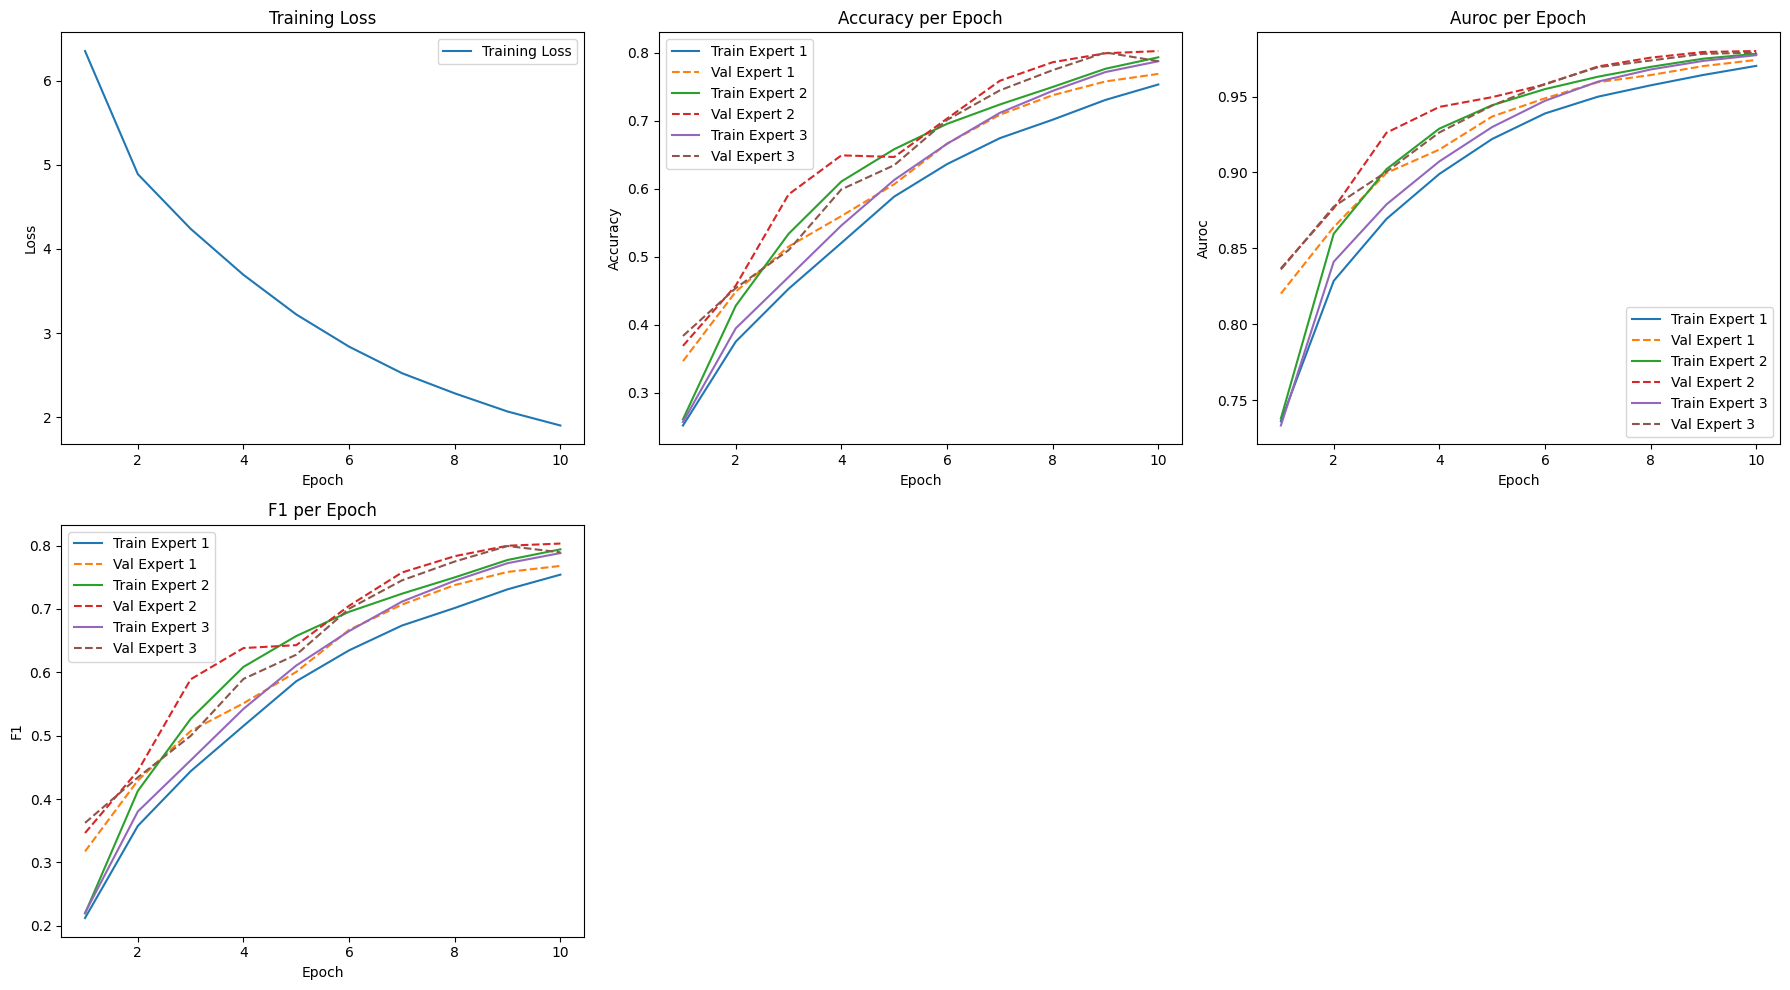

In [88]:
# Correct the calculation of AUROC to handle missing classes in some batches
def calculate_auroc(y_true, y_pred, n_classes=11):  # Include unknown class
   # Binarize true labels to match the shape of predicted probabilities
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))
    # Ensure the binarized labels have the same number of classes as the predictions
    if y_true_binarized.shape[1] != y_pred.shape[1]:
        y_true_binarized = np.hstack([
            y_true_binarized,
            np.zeros((y_true_binarized.shape[0], y_pred.shape[1] - y_true_binarized.shape[1]))
        ])
    auroc_scores = []
    for i in range(y_pred.shape[1]):
      # Check if there is variance in the true labels for the current class
        if len(np.unique(y_true_binarized[:, i])) > 1:
           # Compute AUROC for the current class
            auroc = roc_auc_score(y_true_binarized[:, i], y_pred[:, i])
            auroc_scores.append(auroc)
        else:
            auroc_scores.append(np.nan)  # Safely handle cases with no variance in labels
    valid_auroc_scores = [score for score in auroc_scores if not np.isnan(score)]
    return np.mean(valid_auroc_scores) if valid_auroc_scores else 0

# Update train and evaluation function as necessary to reflect these changes

def train_model_and_collect_metrics(model, train_loader, val_loader, optimizer, scheduler, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # Initialize history to collect metrics
    history = {
        'loss': [],
        'train_accuracy': {f'expert_{idx+1}': [] for idx in range(len(model.experts))},
        'train_auroc': {f'expert_{idx+1}': [] for idx in range(len(model.experts))},
        'train_f1': {f'expert_{idx+1}': [] for idx in range(len(model.experts))},
        'val_accuracy': {f'expert_{idx+1}': [] for idx in range(len(model.experts))},
        'val_auroc': {f'expert_{idx+1}': [] for idx in range(len(model.experts))},
        'val_f1': {f'expert_{idx+1}': [] for idx in range(len(model.experts))}
    }
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        temp_metrics = {mode: {metric: [[] for _ in model.experts] for metric in ['accuracy', 'auroc', 'f1']}
                        for mode in ['train', 'val']}

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            final_output, expert_outputs, attentions = model(inputs)  # Receive attentions here
            final_output = torch.stack(expert_outputs).mean(dim=0)  # Average expert outputs
            loss = model.compute_loss(expert_outputs, labels, attentions)  # Pass expert_outputs to compute_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Collect metrics for each expert

            for idx, output in enumerate(expert_outputs):
                predicted = torch.argmax(output, dim=1)
                accuracy = accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())
                f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
                temp_metrics['train']['accuracy'][idx].append(accuracy)
                temp_metrics['train']['f1'][idx].append(f1)
                auroc = calculate_auroc(labels.cpu().numpy(), torch.softmax(output, dim=1).detach().cpu().numpy())
                temp_metrics['train']['auroc'][idx].append(auroc)

        scheduler.step()
        history['loss'].append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                final_output, expert_outputs, _ = model(inputs)
                final_output = torch.stack(expert_outputs).mean(dim=0)  # Average expert outputs
                for idx, output in enumerate(expert_outputs):
                    predicted = torch.argmax(output, dim=1)
                    accuracy = accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())
                    f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
                    temp_metrics['val']['accuracy'][idx].append(accuracy)
                    temp_metrics['val']['f1'][idx].append(f1)
                    auroc = calculate_auroc(labels.cpu().numpy(), torch.softmax(output, dim=1).cpu().numpy())
                    temp_metrics['val']['auroc'][idx].append(auroc)

        # Collecting and printing metrics per epoch
        for mode in ['train', 'val']:
            for metric in ['accuracy', 'auroc', 'f1']:
                for idx in range(len(model.experts)):
                    history[f'{mode}_{metric}'][f'expert_{idx+1}'].append(np.mean(temp_metrics[mode][metric][idx]))

        print(f'Epoch [{epoch+1}/{num_epochs}] Training Loss: {running_loss / len(train_loader):.4f}')
        for mode in ['train', 'val']:
            print(f'{mode.capitalize()} Metrics:')
            for metric in ['accuracy', 'auroc', 'f1']:
                for idx in range(len(model.experts)):
                    print(f'Expert {idx+1} - {metric.capitalize()}: {history[f"{mode}_{metric}"][f"expert_{idx+1}"][-1]:.4f}')

    return history


# Function to plot metrics
def plot_metrics(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(18, 10))

    # Plot training loss
    plt.subplot(2, 3, 1)
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot metrics for each expert
    metrics = ['accuracy', 'auroc', 'f1']
    for i, metric in enumerate(metrics, 2):  # Start from the second subplot
        plt.subplot(2, 3, i)
        for idx in range(len(model.experts)):
            plt.plot(epochs, history[f'train_{metric}'][f'expert_{idx+1}'], label=f'Train Expert {idx+1}')
            plt.plot(epochs, history[f'val_{metric}'][f'expert_{idx+1}'], '--', label=f'Val Expert {idx+1}')
        plt.title(f'{metric.capitalize()} per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

history = train_model_and_collect_metrics(model, train_loader, val_loader, optimizer, scheduler)
plot_metrics(history)


TESTING MODEL WITH BOTH KNOWN AND UNKNOWN CLASSES

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-de

Overall Test Metrics:
Accuracy: 0.5173
AUROC: 0.9765
F1 Score: 0.6123

Expert 1 Metrics:
Accuracy: 0.5259
AUROC: 0.9729
F1 Score: 0.6270

Expert 2 Metrics:
Accuracy: 0.5233
AUROC: 0.9788
F1 Score: 0.6169

Expert 3 Metrics:
Accuracy: 0.5027
AUROC: 0.9777
F1 Score: 0.5931


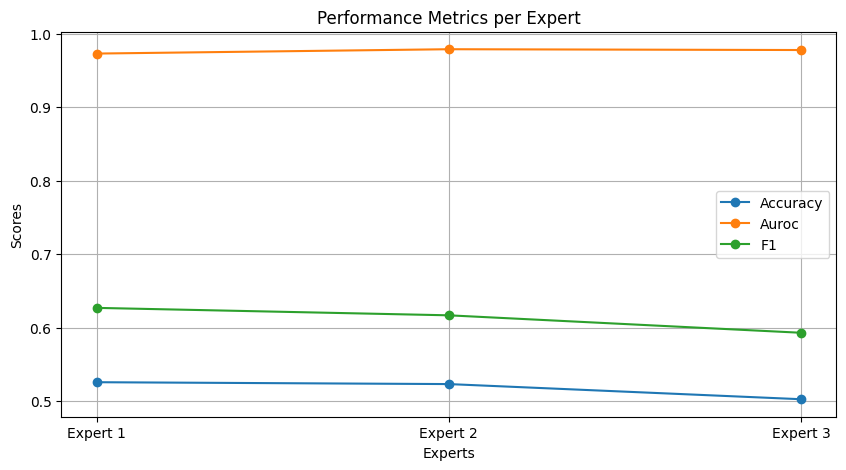

In [91]:
def test_open_set(model, test_loader, device, threshold=0.5):
  # Set the model to evaluation mode
    model.eval()
     # Initialize dictionaries to store metrics for each expert
    all_expert_metrics = {
        'accuracy': [],
        'auroc': [],
        'f1': []
    }
    # Initialize empty lists for each metric for each expert
    for _ in range(len(model.experts)):
        for key in all_expert_metrics:
            all_expert_metrics[key].append([])
    # Disable gradient calculation
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move inputs and targets to the appropriate device
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass through the model
            final_output, expert_outputs, _ = model(inputs)
            # Loop through each expert's output
            for idx, logits in enumerate(expert_outputs):
              # Compute softmax probabilities
                probs = torch.softmax(logits, dim=1)
                # Get the maximum probability and corresponding predicted class
                max_probs, preds = torch.max(probs, dim=1)

                # Apply threshold to determine unknowns
                preds[max_probs < threshold] = 10  # Assign unknown class

                # Calculate metrics
                accuracy = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
                f1 = f1_score(targets.cpu().numpy(), preds.cpu().numpy(), average='weighted', labels=np.arange(11))

                # Handling AUROC calculation
                # First, move tensors to CPU for compatibility with Scikit-learn
                targets_cpu = targets.cpu()
                probs_cpu = probs.cpu()

                try:
                    if len(np.unique(targets_cpu.numpy())) > 1:  # Check if there's more than one class
                        auroc = calculate_auroc(targets_cpu.numpy(), probs_cpu.numpy())
                    else:
                        auroc = float('nan')  # Not enough class variety for AUROC
                except ValueError:
                    auroc = float('nan')  # Handle any error that arises from AUROC calculation
                # Store the metrics for the current batch
                all_expert_metrics['accuracy'][idx].append(accuracy)
                all_expert_metrics['auroc'][idx].append(auroc)
                all_expert_metrics['f1'][idx].append(f1)

    # Average the metrics over all batches
    for key in all_expert_metrics:
        all_expert_metrics[key] = [
            np.nanmean([m for m in metrics if not np.isnan(m)]) for metrics in all_expert_metrics[key]
        ]

    # Print overall test metrics
    print("Overall Test Metrics:")
    print(f"Accuracy: {np.mean(all_expert_metrics['accuracy']):.4f}")
    print(f"AUROC: {np.mean(all_expert_metrics['auroc']):.4f}")
    print(f"F1 Score: {np.mean(all_expert_metrics['f1']):.4f}")

    # Print expert-wise test metrics
    for idx, metrics in enumerate(zip(all_expert_metrics['accuracy'], all_expert_metrics['auroc'], all_expert_metrics['f1']), start=1):
        acc, auroc, f1 = metrics
        print(f"\nExpert {idx} Metrics:")
        print(f"Accuracy: {acc:.4f}")
        print(f"AUROC: {auroc:.4f}")
        print(f"F1 Score: {f1:.4f}")

    return all_expert_metrics

# Plotting function corrected for your needs
def plot_performance_metrics(metrics):
    experts = ['Expert 1', 'Expert 2', 'Expert 3']
    fig, ax = plt.subplots(figsize=(10, 5))
    for key, values in metrics.items():
        ax.plot(experts, values, marker='o', label=key.capitalize())
    ax.set_title('Performance Metrics per Expert')
    ax.set_xlabel('Experts')
    ax.set_ylabel('Scores')
    ax.legend()
    plt.grid(True)
    plt.show()

# Assuming `model`, `device`, and `test_loader` are defined
threshold = 0.5  # Set your confidence threshold for unknown detection
metrics = test_open_set(model, test_loader, device, threshold)
plot_performance_metrics(metrics)


VISUALISING THE PREDICTIONS FROM TEST_LOADER(BOTH KNOWN AND UNKNOWN)

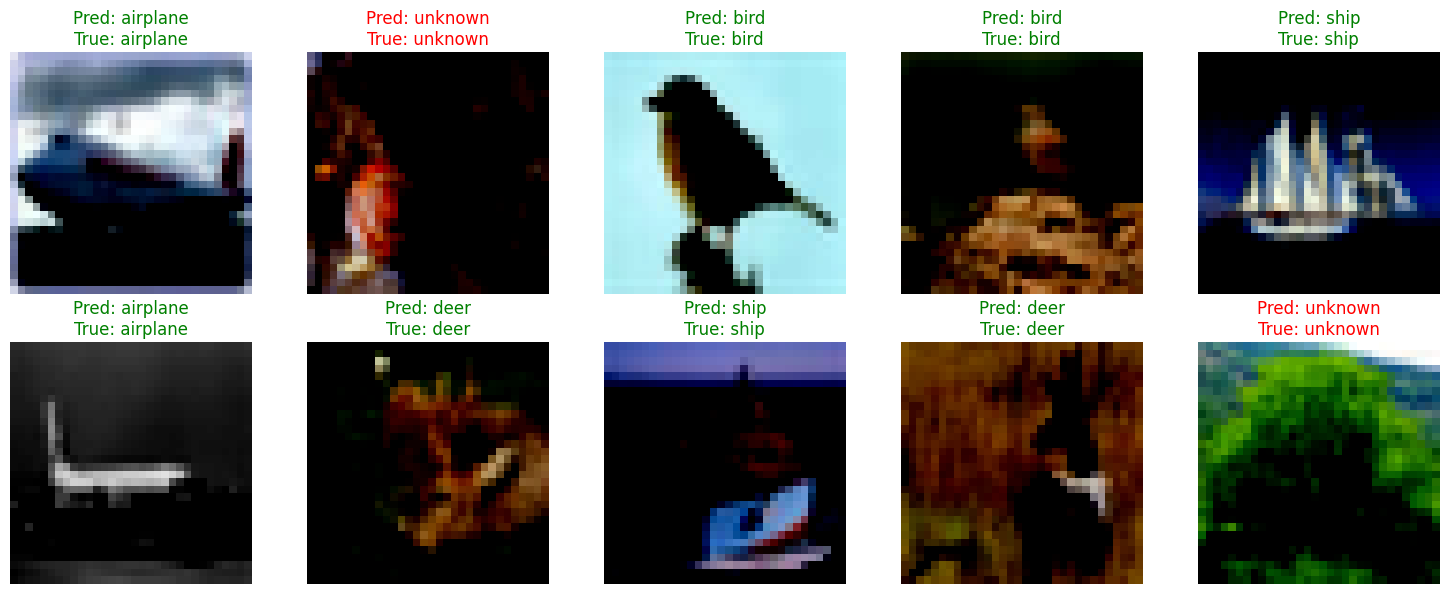

In [80]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def visualize_random_predictions(test_loader, model, class_names, device, num_images=10, num_unknown=2):
    # Set the model to evaluation mode
    model.eval()

    # We need to manually collate our images, so we'll gather a bunch and then select from them
    all_images, all_labels = [], []
    for imgs, lbls in test_loader:
        all_images.append(imgs)
        all_labels.append(lbls)
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    # Find all 'unknown' indices
    unknown_indices = np.where(all_labels == class_names.index('unknown'))[0]

    # Ensure we have enough unknown samples to meet our requirement
    if len(unknown_indices) >= num_unknown:
        # Randomly select two 'unknown' images
        selected_unknown_indices = np.random.choice(unknown_indices, num_unknown, replace=False)
    else:
        raise ValueError(f"Not enough unknown samples to select {num_unknown} of them.")

    # Select remaining images randomly from any class except 'unknown'
    non_unknown_indices = np.where(all_labels != class_names.index('unknown'))[0]
    selected_other_indices = np.random.choice(non_unknown_indices, num_images - num_unknown, replace=False)

    # Combine our selected indices and sample from the dataset
    selected_indices = np.concatenate((selected_unknown_indices, selected_other_indices))
    np.random.shuffle(selected_indices)  # Shuffle the combined set so 'unknowns' aren't all first
    selected_images = all_images[selected_indices]
    selected_labels = all_labels[selected_indices]

    # Move to the appropriate device
    selected_images, selected_labels = selected_images.to(device), selected_labels.to(device)

    # Get predictions
    with torch.no_grad():
        final_output, _, _ = model(selected_images)
        _, preds = torch.max(final_output, 1)

    # Plotting
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5x2 grid for 10 images
    axes = axes.ravel()

    for i, (img, label, pred) in enumerate(zip(selected_images, selected_labels, preds)):
        pred_class = class_names[pred] if label != class_names.index('unknown') else 'unknown'
        true_class = class_names[label]
        axes[i].imshow(img.cpu().numpy().transpose((1, 2, 0)))  # Transpose the image to (H,W,C) format
        axes[i].set_title(f"Pred: {pred_class}\nTrue: {true_class}",
                          color=("green" if pred == label else "red"))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
# Define class_names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'unknown']

# Example usage:
visualize_random_predictions(test_loader, model, class_names, device, num_images=10, num_unknown=2)


